<h1>Chapter 7 - Interventions and Causal effects <br><sub>Online Gaming Case Study</sub>
</h1>

The notebook is a code companion to chapter 7 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/). Load it in Google Colab: <a href="https://github.com/altdeep/causalML/blob/master/book/chapter%207/chapter_7_online_gaming_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

View the [book resources](https://www.altdeep.ai/causalaibook) to see other tutorials and book-related links.

In [54]:
# This code works with the following library versions. Older or more recent versions may work as well.
!pip install pyro-ppl==1.9.0
!pip install pandas==2.2.1
!pip install pgmpy==0.1.25

This tutorial works through the online gaming case study in chapter 7. In this case study, you imagine you are a data scientist at an online role-playing game company. Your leadership wants to know if side-quest engagement (mini-objectives that are tangential to the game's primary objectives) is a driver of in-game purchases of virtual artifacts. If the answer is yes, the company will intervene in the game dynamics such that players engage in more side-quests.

## Listing 7.1: Load side-quest engagement vs in-game purchase data and summarize

We first do a naive correlation analysis on observational <i>observational data</i>. In contrast to <i>experimental data</i>, we call this "observational data" because it is logged observations of the natural behavior of players as they log in and play. First, we download the data and generate summary statistics.

In [55]:
import pandas as pd
data_url = (    #A
    "https://raw.githubusercontent.com/altdeep/causalML/master/"    #A
    "datasets/sidequests_and_purchases_obs.csv"    #A
)    #A
df = pd.read_csv(data_url)    #A
summary = df.drop('User ID', axis=1).groupby(    #B
    ["Side-quest Engagement"]    #B
).agg(    #C
    ['count', 'mean', 'std']    #C
)    #C
summary

#A Load the data from the database query into a pandas dataframe.
#B For each level of side-quest engagement ("low", "high")...
#C Calculate the sample count (number of players), the sample mean in-game purchase amount, and the standard deviation.

In-game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                482  111.609461  55.562334
low                                 518   73.096371  75.947688

## Listing 7.2: Test if the (observational) difference in mean in-game purchases is statistically significant

We want to know if there is a significant difference in in-game purchases between players with high side-quest engagement and players with low side-quest engagement. Below, we look at the difference in means between the two groups. The difference is positive, but just to be rigorous, we run a simple statistical test for significance. The following test computes a z-score. We'll conclude the difference is significant if the z-score is more than two standard deviations from the mean (roughly close to a significance level of .05).

In [56]:
n1, n2 = summary['In-game Purchases']['count']    #A
m1, m2 = summary['In-game Purchases']['mean']    #B
s1, s2 =  summary['In-game Purchases']['std']    #C
pooled_std = (s1**2 / n1 + s2**2 / n2) **.5    #D
z_score = (m1 - m2) / pooled_std    #E
abs(z_score) > 2.  #F
#A n1 and n2 are the number of players in each group (high vs low engagement).
#B m1 and m2 are the group sample means.
#C s1 and s2 are the group standard deviations.
#D Estimate the standard error of the difference in mean spend by pooling (combining) the group standard deviations.
#E Convert to a z-score, which has a standard norm under the (null) hypothesis of no difference in spend across engagement levels.
#F Tests if the z-score is more than 2 standard deviations from 0, which beats a 5% significance threshold.

True

The difference is significant. If you reported this result to your leadership, they might decide to modify the game to encourage more side-quest engagement.

## Listing 7.3: Load experimental data and summarize

But this would be a mistake. To see why, we look at data from an experiment that randomly assigned players to a groups where one group was encouraged to have high side-quest engagement and the other group was encouraged to have lower engagement. Let's repeat the analysis with this data.

In [57]:
import pandas as pd
exp_data_url = (    #A
    "https://raw.githubusercontent.com/altdeep/causalML/master/"    #A
    "datasets/sidequests_and_purchases_exp.csv"    #A
)    #A
df = pd.read_csv(exp_data_url)    #A
summary = df.drop('User ID', axis=1).groupby(    #B
    ["Side-quest Engagement"]    #B
).agg(    #C
    ['count', 'mean', 'std']    #C
)
print(summary)
#A Load the experimental data from the database query into a pandas dataframe.
#B For each level of side-quest engagement ("low", "high")…
#C …calculate the sample count (number of players), the sample mean in-game purchase amount, and the standard deviation.

                      In-game Purchases                      
                                  count       mean        std
Side-quest Engagement                                        
high                                500   92.99054  51.673631
low                                 500  131.38228  94.840705


## Listing 7.4: Test if the (experimental) difference in mean in-game purchases is statistically significant.

In [58]:
n1, n2 = summary['In-game Purchases']['count']    #A
m1, m2 = summary['In-game Purchases']['mean']    #B
s1, s2 =  summary['In-game Purchases']['std']    #C
pooled_std = (s1**2 / n1 + s2**2 / n2) **.5    #D
z_score = (m1 - m2) / pooled_std    #E
abs(z_score) > 2.    #F
#A n1 and n2 are the number of players in each group (high vs low engagement).
#B m1 and m2 are the group sample means.
#C s1 and s2 are the group standard deviations.
#D Estimate the standard error of the difference in mean spend by pooling (combining) the group standard deviations.
#E Convert to a z-score, which has a standard norm under the (null) hypothesis of no difference in spend across engagement levels.
#F Tests if the z-score is more than 2 standard deviations from 0, which beats a 5% significance threshold.

True

We still get a statistically different result, but the effect size is negative.

Obviously, experimental results are preferable to observational results. Statistical common sense tells us that correlation does not imply causality, and that the difference in group means reflects correlation in the observational study, and refects causation in the experimental study.

Experimental data is great, but it may not be readily available. Acquiring experimental data may be infeasible and when it is feasible, it has a cost. Even in cases when it is cheap and easy to run experiments, like in an online media company, there are still <i>opportunity costs</i> to running experiments -- see the book for discussion.

Ideally, we could achieve the results we got with experimental data with only the observational data simply by incorporating some causal assumptions into that analysis. We do that next.

# Building a generative model for use in simulating the experiment with intervention.

Next, we assume the following causal DAG.

![online game DAG](images/online-game-dag.png)

Here, we introduce Guild Membership - whether a player belongs to a player guild - as a common cause of side-quest engagement and in-game purchases.

Next, we use Pyro to build a full causal generative model on the observational data. First, we'll download the full observational data inclusive of guild membership. We'll then use that data to estimate some parameters for this model.

## Listing 7.5: Estimate the probability distribution of Guild Membership

In [59]:
import pandas as pd
full_obs_url = (    #A
    "https://raw.githubusercontent.com/altdeep/causalML/master/"    #A
    "datasets/sidequests_and_purchases_full_obs.csv"    #A
)    #A
df = pd.read_csv(full_obs_url)     #A

First, we'll estimate the marginal distribution of guild membership.

In [60]:
membership_counts = df['Guild Membership'].value_counts()    #B
dist_guild_membership = membership_counts / sum(membership_counts)    #B
print(dist_guild_membership)    #B
#A Load the data from the database query into a pandas dataframe.
#B Calculate the proportions of members vs. nonmembers

Guild Membership
nonmember    0.515
member       0.485
Name: count, dtype: float64


In [61]:
dist_guild_membership.member

0.485

## Listing 7.6: Estimate the conditional probability distribution of Side-quest Engagement given Guild Membership

Next, we calculate the probability distribution of side-quest engagement for guild members and nonmembers respectively. First we calculate the probability distribution of side-quest engagement level ("high" vs "low") given that a player is a member of a guild, then we calculate the probability distribution of side-quest engagement level given that a player is not a member of a guild.

In [62]:
member_subset = df[(df['Guild Membership'] == 'member')]    #A
member_engagement_counts = (    #A
    member_subset['Side-quest Engagement'].value_counts()    #A
)    #A
dist_engagement_member = (    #A
    member_engagement_counts / sum(member_engagement_counts)    #A
)    #A
print(dist_engagement_member)    #A

nonmember_subset = df[(df['Guild Membership'] == 'nonmember')]    #B
nonmember_engagement_counts = (    #B
    nonmember_subset['Side-quest Engagement'].value_counts()    #B
)    #B
dist_engagement_nonmember = (    #B
    nonmember_engagement_counts / sum(nonmember_engagement_counts)    #B
)    #B
print(dist_engagement_nonmember)    #B
#A Calculate the probability distribution of side-quest engagement level ("high" vs "low") given that a player is a member of a guild.
#B Calculate the probability distribution of side-quest engagement level ("high" vs "low") given that a player is not a member of a guild.

Side-quest Engagement
high    0.797938
low     0.202062
Name: count, dtype: float64
Side-quest Engagement
low     0.815534
high    0.184466
Name: count, dtype: float64


Next, for each combination of guild membership and side-quest engagement, calculate the mean and standard deviation of in-game purchases.

## Listing 7.7: Calculate the mean and standard deviation of in-game purchases within each combination of level of side-quest engagement and guild membership status

In [63]:
# Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with low side-quest engagement.
purchase_dist_nonmember_low_engagement = df[    #A
    (df['Guild Membership'] == 'nonmember') &    #A
    (df['Side-quest Engagement'] == 'low')    #A
].drop(     #A
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1     #A
).agg(['mean', 'std'])     #A
print(round(purchase_dist_nonmember_low_engagement, 2))    #A

# Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with high side-quest engagement.
purchase_dist_nonmember_high_engagement = df[    #B
    (df['Guild Membership'] == 'nonmember') &    #B
    (df['Side-quest Engagement'] == 'high')    #B
].drop(    #B
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1    #B
).agg(['mean', 'std'])    #B
print(round(purchase_dist_nonmember_high_engagement, 2))    #B

# Estimate the sample mean and standard deviation of in-game purchases for guild-members with low side-quest engagement.
purchase_dist_member_low_engagement = df[    #C
    (df['Guild Membership'] == 'member') &    #C
    (df['Side-quest Engagement'] == 'low')    #C
].drop(    #C
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1    #C
).agg(['mean', 'std'])    #C
print(round(purchase_dist_member_low_engagement, 2))    #C

# Estimate the sample mean and standard deviation of in-game purchases for guild-members with high side-quest engagement.
purchase_dist_member_high_engagement = df[    #D
    (df['Guild Membership'] == 'member') &    #D
    (df['Side-quest Engagement'] == 'high')    #D
].drop(    #D
  ['User ID', 'Side-quest Engagement', 'Guild Membership'], axis=1    #D
).agg(['mean', 'std'])     #D
print(round(purchase_dist_member_high_engagement, 2))    #D
#A Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with low side-quest engagement.
#B Estimate the sample mean and standard deviation of in-game purchases for non-guild-members with high side-quest engagement.
#C Estimate the sample mean and standard deviation of in-game purchases for guild-members with low side-quest engagement.
#D Estimate the sample mean and standard deviation of in-game purchases for guild-members with high side-quest engagement.

      In-game Purchases
mean              37.95
std               23.80
      In-game Purchases
mean              54.92
std                4.92
      In-game Purchases
mean             223.71
std                5.30
      In-game Purchases
mean             125.53
std               53.44


## Listing 7.8 Building a causal model of In-Game Purchases in pyro

We'll use these sample statistics as parameter values in a generative model on the causal DAG. For Guild Membership and Side-Quest engagement, we'll use the sample proportions to estimate Bernoulli parameters. For in-game purchases, we use a normal distributions.

In [64]:
import pyro
from torch import tensor
from pyro.distributions import Bernoulli, Normal

def model():
    p_member = tensor(0.5)    #A
    is_guild_member = pyro.sample(    #A
        "Guild Membership",    #A
        Bernoulli(p_member)    #A
    )    #A
    p_engaged = (tensor(0.8)*is_guild_member +    #B
                 tensor(.2)*(1-is_guild_member))    #B
    is_highly_engaged = pyro.sample(    #B
        "Side-quest Engagement",    #B
        Bernoulli(p_engaged)    #B
    )    #B
    get_purchase_param = lambda param1, param2, param3, param4: (    #C
        param1 * (1-is_guild_member) * (1-is_highly_engaged) +    #C
        param2 * (1-is_guild_member) * (is_highly_engaged) +    #C
        param3 * (is_guild_member)   * (1-is_highly_engaged) +    #C
        param4 * (is_guild_member)   * (is_highly_engaged)    #C
    )    #C
    μ = get_purchase_param(37.95, 54.92, 223.71, 125.50)    #D
    σ = get_purchase_param(23.80, 4.92, 5.30, 53.49)    #D
    in_game_purchases = pyro.sample(   #D
        "In-game Purchases",   #D
        Normal(μ, σ)    #D
    )   #D
    guild_membership = "member" if is_guild_member else "nonmember"    #E
    engagement = "high" if is_highly_engaged else "low"    #E
    in_game_purchases = float(in_game_purchases)    #E
    return guild_membership, engagement, in_game_purchases    #E
#A Probability of being a guild member vs. a non-member is .5. Using this probability, we generate a guild membership value (1 for member, 0 for nonmember) from a Bernoulli distribution.
#B We generate a value for side-quest engagement from a Bernoulli distribution (1 for high, 0 for low) with parameter that depends on guild membership.
#C Helper function for calculating parameters for in-game purchases.
#D I specify the location parameter of a Normal distribution on in-game purchases using the sample means we found in the observational data.
#E As with the mean parameters, we specify the scale parameters for a canonical distribution on in-game purchases using the standard deviations we found in the data.
#F I use the normal distribution to model in-game purchases.
#G Convert the variable values data types in the original data.

Note that the normal distribution isn't ideal for the case of non-guild-members with low side-quest engagement because the low mean and large scale parameter means we'll generate many negative values.  In-game purchases of course cannot be negative.

For our purposes, this is not that big a deal. But it is important to note that unlike pgmpy, Pyro gives us tremendous parameteric flexibility, and we could use that flexibility to address this issue. For example, we could use a [half-normal distribution](https://en.wikipedia.org/wiki/Half-normal_distribution).  Generating from the half-normal distribution is the same as generating from the normal, except any negative values will have their sign changed to positive.  Since this will happen only about 5.5% of the time with negative values close to zero, it would add minimal bias to the mean for this group.

We and use `pyro.render` to confirm that the generative model adheres to our causal DAG.

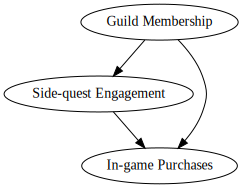

In [65]:
pyro.render_model(model)

Next, we can simulate tfrom the model and confirm that it has a distribution similar to the observational data.

Let's look at the distribution of in-game purchases given side-quest engagement.

In [66]:
pyro.util.set_rng_seed(123)
simulated_observational_data = [model() for _ in range(1000)]
sim_full_obs_df = pd.DataFrame(
    simulated_observational_data,
    columns=["Guild Membership", "Side-quest Engagement", "In-Game Purchases"]
)
sim_obs_df = sim_full_obs_df.drop("Guild Membership", axis=1)
sim_obs_df.groupby(["Side-quest Engagement"]).agg(['count', 'mean', 'std'])

In-Game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                500  108.961974  56.128941
low                                 500   73.950664  74.599295

We compare this to the observational distribution in the actual data.

In [67]:
df.drop(["Guild Membership", "User ID"], axis=1).groupby(["Side-quest Engagement"]).agg(['count', 'mean', 'std'])


In-game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                482  111.609461  55.562334
low                                 518   73.096371  75.947688

## Listing 7.9: Representing interventions with pyro.do

Next, we confirm that our model can simulate data similar to our experimental data. We do this by using Pyro's intervention operator `pyro.do`. We use `pyro.do` to create two models, one that sets engagement to high, the other to low.

In [68]:
int_engaged_model = pyro.do(    #A
    model,    #A
    {"Side-quest Engagement": tensor(1.)}    #A
)    #A
int_unengaged_model = pyro.do(    #B
    model,    #B
    {"Side-quest Engagement": tensor(0.)}    #B
)    #B
#A An intervention that sets Side-quest Engagement to 1.0 (i.e., "high"). This returns a new model.
#B An intervention that sets Side-quest Engagement to 0.0 (i.e., "low"). This returns a new model.

## Listing 7.10: Simulating experimental data with pyro.do interventions

Next, we simulate from both models and combine the results to get simulated experimental data.

In [69]:
pyro.util.set_rng_seed(123)    #A
simulated_experimental_data = [    #B
    int_engaged_model() for _ in range(500)    #B
] + [    #B
    int_unengaged_model() for _ in range(500)    #B
]    #B
simulated_experimental_data = pd.DataFrame(    #B
    simulated_experimental_data,    #B
    columns=[    #B
        "Guild Membership",    #B
        "Side-quest Engagement",    #B
        "In-Game Purchases"    #B
    ]    #B
)    #B
sim_exp_df = simulated_experimental_data.drop(    #C
    "Guild Membership", axis=1)    #C
summary = sim_exp_df.groupby(    #D
        ["Side-quest Engagement"]    #D
    ).agg(    #D
        ['count', 'mean', 'std']    #D
    )    #D
print(summary)    #D
#A Setting a random seed for reproducibility.
#B Simulate 500 rows from each intervention model and combine them to create simulated experimental data.
#C The simulated data will include a Guild Membership column. We can drop it to get simulated data that looks like the original experiment.
#D Recreate the statistical summaries of in-game purchases for each level of engagement.

                      In-Game Purchases                       
                                  count        mean        std
Side-quest Engagement                                         
high                                500   89.897309  52.696709
low                                 500  130.674021  93.921543


We see that this gives us a distribution similar to the actual experimental data.

In [70]:
exp_data_url = (
    "https://raw.githubusercontent.com/altdeep/causalML/master/"
    "datasets/sidequests_and_purchases_exp.csv"
)
exp_df = pd.read_csv(exp_data_url)

summary = exp_df.drop('User ID', axis=1).groupby(
        ["Side-quest Engagement"]
    ).agg(
        ['count', 'mean', 'std']
    )
print(summary)

                      In-game Purchases                      
                                  count       mean        std
Side-quest Engagement                                        
high                                500   92.99054  51.673631
low                                 500  131.38228  94.840705


In summary, we can use our observational data to train a causal model that can simulate experimental data. In other words, the causal model and its intervention operator allows us to "bootstrap" our observational data into experimental data.

## Listing 7.11: Graph mutilation on a DAG in pgmpy

We need an intervention operator that changes our causal graph to reflect this broken causal dependency. This intervention operator is called graph mutilation (also known as graph surgery) and is illustrated in the following figure.

![Graph Mutilation](images/graph_mutilation.png)

Graph mutilation removes incoming edge to the intervention target Side-quest Engagement.
While Guild Membership is a cause of side-quest engagement in normal settings, the experiment’s intervention on Side-quest Engagement broke that variable’s causal dependence on Guild Membership. Since that causal dependence is gone, graph mutilation changes the graph to one where the edge from Guild Membership to Side-quest engagement is snipped.
Suppose you have a causal graph with node X. You want to apply an intervention do(X=x). Then, you represent that intervention on the causal DAG by “mutilating” the DAG by removing all incoming edges to X.
Graph mutilation is available in libraries such as pgmpy.


In [71]:
from pgmpy.base import DAG

G = DAG([    #A
    ('Guild Membership', 'Side-quest Engagement'),    #A
    ('Side-quest Engagement', 'In-game Purchases'),    #A
    ('Guild Membership', 'In-game Purchases')    #A
])    #A
G_int = G.do('Side-quest Engagement')    #B
# A Build the causal DAG.
# B The "do" method in the DAG class applies graph mutilation.

## Listing 7.12 Plot the mutilated DAG

We can now plot both the original DAG and the mutilated DAG and compare.

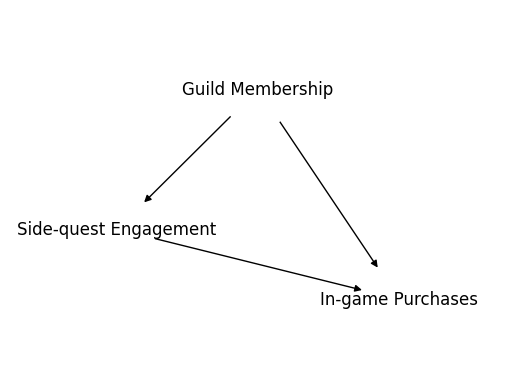

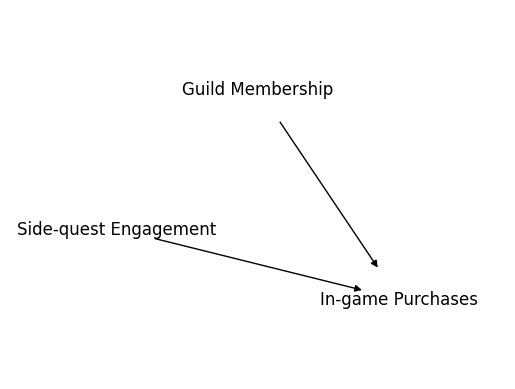

In [72]:
import pylab as plt
import networkx as nx

pos = {    #A
    'Guild Membership': [0.0, 1.0],    #A
    'Side-quest Engagement': [-1.0, 0.0],    #A
    'In-game Purchases': [1.0, -0.5]    #A
}    #A

ax = plt.subplot()    #B
ax.margins(0.3)    #B
nx.draw(G, ax=ax, pos=pos, node_size=3000,    #B
        node_color='w', with_labels=True)    #B
plt.show()    #B

ax = plt.subplot()    #C
ax.margins(0.3)    #C
nx.draw(G_int, ax=ax, pos=pos,    #C
        node_size=3000, node_color='w', with_labels=True)    #C
plt.show()    #C
#A Create a dictionary of node positions that we can use to visualize both graphs.
#B Visualize the original graph.
#C Visualize the mutilated graph.

## Listing 7.13 Revisiting pyro.do

In [73]:
int_engaged_model = pyro.do(    #A
    model,    #A
    {"Side-quest Engagement": tensor(1.)}    #A
)    #A
int_unengaged_model = pyro.do(    #B
    model,    #B
    {"Side-quest Engagement": tensor(0.)}    #B
)    #B
#A An intervention that sets Side-quest Engagement to 1.0 (i.e., "high"). This returns a new model.
#B An intervention that sets Side-quest Engagement to 0.0 (i.e., "low"). This returns a new model.

What exactly does pyro.do do? pyro.do is Pyro’s intervention operator. We saw, by using pyro.render_model to generate Figure 7.4, that our online gaming model in Pyro has an underlying causal DAG, and therefore is a causal graphical model.
But a deep probabilistic machine learning framework like Pyro allows you to do things that we can’t easily represent with a causal DAG, such as recursion, conditional control flow, or having a random number of variables not realized until runtime. As an intervention operator, pyro.do must work in these cases as well.
The intervention operator in Pyro works by finding calls to pyro.sample, and replacing that call with an assignment to the intervention value. For example, the online game model had the following line:

`is_highly_engaged = pyro.sample("Side-quest Engagement", Bernoulli(p_engaged))`

This pyro.sample call generates a value for Side-quest Engagement. `pyro.do(model, {"Side-quest Engagement": tensor(1.)})` essentially replaces that line with:
`is_highly_engaged = tensor(1.)`
(I say “essentially” because pyro.do does a few other things too, which I discuss in chapter 9).
This replacement is much like the replacement of the assignment function in the SCM, or a causal Markov kernel with a degenerate kernel in a causal graphical model. As an intervention operator, it meets the criteria for an ideal intervention. It targets a specific variable and it assigns it a specific value. It eliminates its dependence on its causes by removing flow dependence (dependence on results of executing preceding statements in the program).
